This notebook contains the code for reproducing Figure 3
It only loads the data for November of each Year because of the sheer amount of games.

# Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
%config Completer.use_jedi = False
sns.set(rc={'figure.figsize':(14,8)})

In [2]:
dfs = []
for f in glob('lichess_db_analyzed_*-11.csv'):
    print(f)
    dfs.append(pd.read_csv(f))
df = pd.concat(dfs)

lichess_db_analyzed_2018-11.csv
lichess_db_analyzed_2016-11.csv
lichess_db_analyzed_2020-11.csv
lichess_db_analyzed_2019-11.csv
lichess_db_analyzed_2015-11.csv
lichess_db_analyzed_2021-11.csv
lichess_db_analyzed_2017-11.csv


# Preprocess Data

In [3]:
df['UTCDate'] = pd.to_datetime(df.UTCDate)
df = df.sort_values('UTCDate')

print('Games Before processing',len(df))

#drop any potential bad data we got from parsing
#for example games with only 1 move or no Rating for some side
df = df.dropna()

#remove Correspondence games
df = df[df.Event!='C']

#remove short games
df = df[df.gameLength>=10] 

#remove large acpl
df = df[df.whiteACPL<=500]
df = df[df.blackACPL<=500]

#remove extreme Elos 
df = df[df.WhiteElo>=800]
df = df[df.BlackElo>=800] 
df = df[df.WhiteElo<=2750] 
df = df[df.BlackElo<=2750]

#remove aborted games
df = df[df.Result!='?']

#remove provisional or cheated games
df = df[df.Termination!='?'] 

#Rename Elo to rating
df = df.rename(columns={'WhiteElo': 'White Rating', 'BlackElo': 'Black Rating',
                        'Event':'Time Control'})

#bin Elo for plotting
bins = np.arange(min(min(df['White Rating']),min(df['Black Rating'])),
                 max(max(df['White Rating'])+1,max(df['Black Rating'])+1),150)
labels=[str(x)+'-'+str(y) for x,y in zip(bins,bins[1:])]
df['White Rating Range'] = pd.cut(df['White Rating'], bins, labels=labels)
df['Black Rating Range'] = pd.cut(df['Black Rating'], bins, labels=labels)

#Rename Time controls for plotting
df['Time Control'] = df['Time Control'].replace({'b':'Bullter', 'B':'Blitz', 'R':'Rapid', 'c':'Classical'})

print('Games after processing',len(df))


Games Before processing 18609075
Games after processing 18300150


# Figure 3

In [4]:
print(df['UTCDate'].dt.year.value_counts())

2021    6911606
2020    4717312
2019    2207694
2018    1846409
2017    1070090
2016     963132
2015     583907
Name: UTCDate, dtype: int64


In [5]:
#could have used groupby
bullet = df[df['Time Control'] == 'Bullet']
blitz = df[df['Time Control'] == 'Blitz']
rapid = df[df['Time Control'] == 'Rapid']
classical = df[df['Time Control'] == 'Classical']  

all_modes = [bullet, blitz, rapid, classical]


In [6]:
heatmap = pd.pivot_table(blitz, values='whiteACPL', columns='White Rating Range',
                         index=blitz.UTCDate.dt.year, aggfunc=np.mean)
heatmap

White Rating Range,800.0-950.0,950.0-1100.0,1100.0-1250.0,1250.0-1400.0,1400.0-1550.0,1550.0-1700.0,1700.0-1850.0,1850.0-2000.0,2000.0-2150.0,2150.0-2300.0,2300.0-2450.0,2450.0-2600.0,2600.0-2750.0
UTCDate,,,,,,,,,,,,,
2015,87.089800,84.219358,74.851696,66.612003,59.539891,54.629742,49.603123,44.134746,40.545420,36.813139,32.786198,29.041062,24.870739
2016,98.259465,93.790996,83.363110,74.022108,65.652779,60.652168,55.370812,50.534999,45.882560,42.284389,39.693564,36.819201,34.618045
2017,103.082586,91.356594,81.139692,72.814674,66.067780,61.831744,57.213379,52.769866,48.680490,44.949498,42.460904,40.305595,36.776659
2018,106.516798,93.168875,83.476657,76.367040,70.058883,65.742794,61.359338,56.937911,52.410113,48.414296,43.730152,42.628938,38.258184
2019,108.753297,97.788318,87.757822,80.775584,74.624606,70.069479,65.745077,61.024695,56.810232,51.539554,46.876306,43.276445,40.450016
2020,115.156165,103.160709,93.629835,86.387117,79.737773,74.508736,69.494978,64.386368,59.565977,54.630316,49.658119,45.571351,42.659952
2021,115.637276,104.560985,96.367850,90.291418,84.336653,79.622560,75.125817,70.787859,66.122853,61.102571,55.575607,51.002439,46.218728


In [7]:
#Check that we have enough in each category
pd.pivot_table(blitz, values='whiteACPL', columns='White Rating Range',
                         index=blitz.UTCDate.dt.year, aggfunc='count')

White Rating Range,800.0-950.0,950.0-1100.0,1100.0-1250.0,1250.0-1400.0,1400.0-1550.0,1550.0-1700.0,1700.0-1850.0,1850.0-2000.0,2000.0-2150.0,2150.0-2300.0,2300.0-2450.0,2450.0-2600.0,2600.0-2750.0
UTCDate,,,,,,,,,,,,,
2015,297,2229,7618,16910,29439,35785,31316,20738,10612,4505,1511,397,119
2016,889,4579,14889,33011,58454,67830,62933,46560,24232,11015,4593,1623,496
2017,5222,18755,39291,61749,83730,78840,67528,46386,25836,11342,3905,1401,258
2018,25288,60819,93402,117780,134202,119821,98140,69063,39342,18420,7615,3155,1140
2019,20090,59661,103212,130615,152032,144408,128870,99309,67022,34681,15608,4552,1213
2020,67305,149344,217075,267636,311269,286157,262305,214025,157200,91286,41213,14065,3680
2021,79914,189227,287747,358001,429895,406817,394038,348880,278948,211952,180544,137956,49984


[Text(0.5, 0, 'Year'), Text(0, 0.5, 'ACPL')]

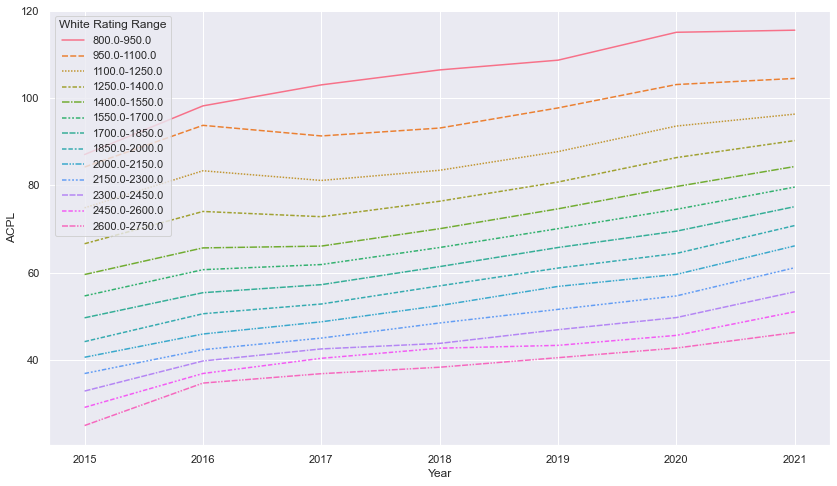

In [8]:
ax = sns.lineplot(data=heatmap)
ax.set(xlabel='Year', ylabel='ACPL')

# Extra 

<AxesSubplot:xlabel='White Rating Range', ylabel='UTCDate'>

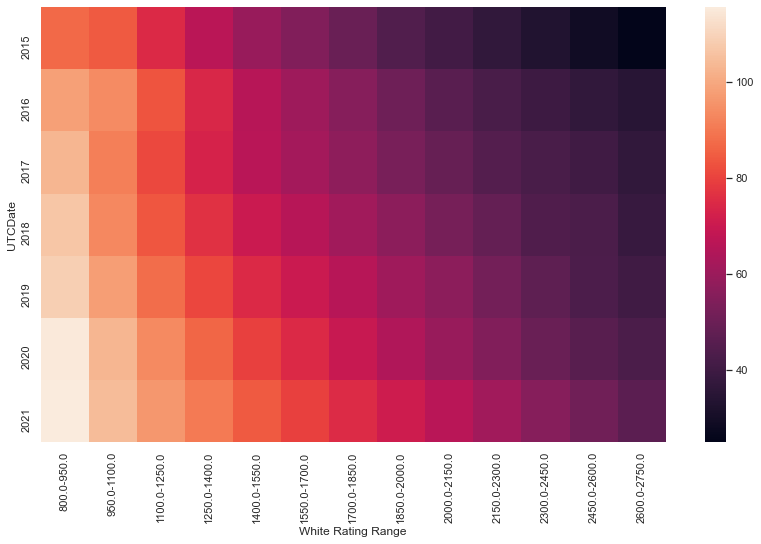

In [9]:
sns.heatmap(heatmap)

<bound method Axes.set_title of <AxesSubplot:xlabel='Year', ylabel='ACPL'>>

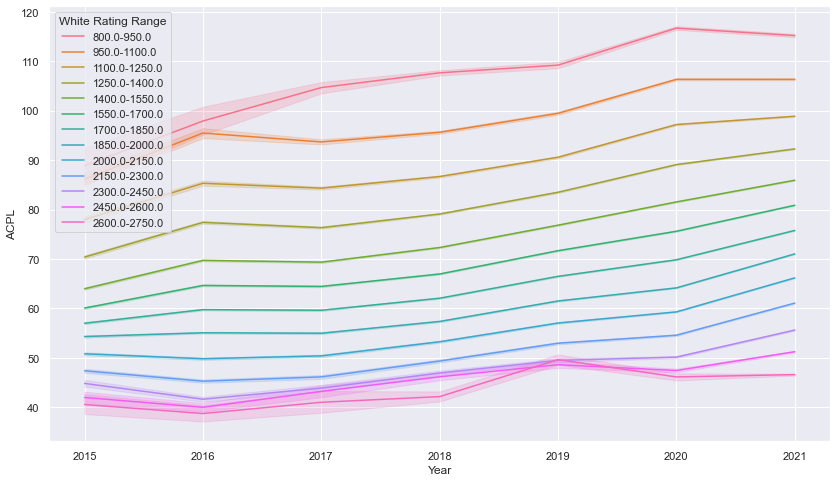

In [10]:
#lineplot aggragates the repeated values and provides confidence interval. Not the same as mean.
ax = sns.lineplot(
    data=df, x=df.UTCDate.dt.year, y="whiteACPL", hue="White Rating Range"
)
ax.set(xlabel='Year', ylabel='ACPL')
ax.set_title